<a href="https://colab.research.google.com/github/Baranek44/TextToImage/blob/main/TextToImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. 
# It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly 
# optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3.
!git clone https://github.com/openai/CLIP.git

# Efficiancy of convolutional approaches with the expressivity of transformers by introducing a convolutional VQGAN, 
# which learns a codebook of context-rich visual parts, whose composition is modeled with an autoregressive transformer.
# For High resolution image synthesis
!git clone https://github.com/CompVis/taming-transformers

Cloning into 'CLIP'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 164 (delta 31), reused 49 (delta 19), pack-reused 91
Receiving objects: 100% (164/164), 8.87 MiB | 19.20 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1041, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 1041 (delta 4), reused 219 (delta 3), pack-reused 810
Receiving objects: 100% (1041/1041), 350.31 MiB | 34.09 MiB/s, done.
Resolving deltas: 100% (213/213), done.


In [2]:
# Instaling libraries
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

     |████████████████████████████████| 64 kB 1.4 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=9076ff0d6f03f4945ff72869bbc169fa158247e5e21ef1f78e923821b5eff4f3
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
     |████████████████████████████████| 561 kB 3.6 MB/s 
     |████████████████████████████████| 829 kB 28.1 MB/s 
     |████████████████████████████████| 123 kB 45.9 MB/s 
     |████████████████████████████████| 636 kB 35.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=b833b4af89474e3120ad2dc570dc7ddf9acc5c8a7b6ae1967b310f540504e3b5
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  

In [3]:
# Importing libraries
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import yaml
from omegaconf import OmegaConf

from CLIP import clip

# importing warning

In [4]:
## Helper functions

def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def norm_data(data):
  return (data.clip(-1, 1) + 1) / 2 ## we need range between 0 and 1 

## Parameters
learning_rate = .5
batch_size = 1
wd = .1
noise_factor = .33

total_iter = 400
im_shape = [650, 650, 3] ## height, width, channel
size1, size2, channels = im_shape

In [5]:
# Clip model
# Connect text to images
clipmodel, _ = clip.load('ViT-B/32', jit = False)
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution: ", clipmodel.visual.input_resolution)

device = torch.device("cuda:0")
torch.cuda.empty_cache()


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 49.8MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']
Clip model visual input resolution:  224


In [6]:
# Taming transformer instantiation

%cd taming-transformers/ 

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
  !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
  !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'

/content/taming-transformers
--2021-10-01 13:35:21--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/4c00c2a3-005c-4a39-935f-62f3d974fab6/last.ckpt [following]
--2021-10-01 13:35:21--  https://heibox.uni-heidelberg.de/seafhttp/files/4c00c2a3-005c-4a39-935f-62f3d974fab6/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  14.9MB/s    in 63s     

2021-10-01 13:36:24 (14.9 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/980

In [7]:
from taming.models.vqgan import VQModel

def load_config(config_path, display = False):
  config_data = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config_data)))
  return config_data

def load_vqgan(config, chk_path = None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location = "cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(state_dict, strict = False)
  return model.eval()

def generator(x): 
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display = True)
taming_model = load_vqgan(taming_config, chk_path = "./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 455kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [8]:
# Declate the values that we are going to optimize

class Parameters(torch.nn.Module):
  def __init__(self):
    super(Parameters, self).__init__()
    self.data = .5*torch.randn(batch_size, 256, size1 // 16, size2 // 16).cuda() # 1 x 256 x 14 x 15 (225/16, 400/16)
    self.data = torch.nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

def init_params():
  params = Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr': learning_rate}], weight_decay = wd)
  return params, optimizer


torch.Size([1, 256, 40, 40])
img dimensions:  torch.Size([1, 3, 640, 640])


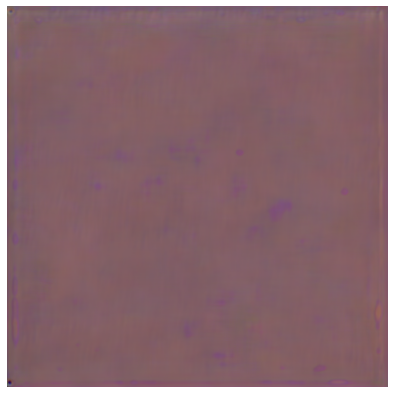

In [9]:
# Encoding prompts and a few more things

normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
  t = clip.tokenize(text).cuda()
  t = clipmodel.encode_text(t).detach().clone()
  return t

def createEncoding(include, exclude, extras):
  include_enc = []
  for text in include:
    include_enc.append(encodeText(text))
  exclude_enc = encodeText(exclude) if exclude != '' else 0
  extras_enc = encodeText(extras) if extras != '' else 0

  return include_enc, exclude_enc, extras_enc

augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill = 0)
).cuda()

Params, optimizer = init_params()

with torch.no_grad():
  print(Params().shape)
  img = norm_data(generator(Params()).cpu()) # 1x 3 x 224 x 400 [225 x 400]
  print("img dimensions: ", img.shape)
  show_from_tensor(img[0])

In [10]:
# create crops

def create_crops(img, num_crops = 30):
  p = size1 // 2
  img = torch.nn.functional.pad(img, (p, p, p, p), mode = 'constant', value = 0) # 1 x 3 x 448 x 624 (adding 112 * 2 on all sides to 224 x 400)

  img = augTransform(img) # RandomoHorizontalFlip and RanomAffine

  crop_set = []
  for ch in range(num_crops):
    gap1 = int(torch.normal(1.2, .5, ()).clip(.5, 1.9) * size1)
    # gap2 = int(torch.normal(1.0, .5, ()).clip(.2, 1.5) * size1)
    offsetx = torch.randint(0, int(size1 * 2 - gap1), ())
    offsety = torch.randint(0, int(size1 * 2 - gap1), ())

    crop = img[:,:,offsetx:offsetx + gap1, offsety:offsety + gap1]

    crop = torch.nn.functional.interpolate(crop,(224, 224), mode = 'bilinear', align_corners = True)
    crop_set.append(crop)

  img_crops = torch.cat(crop_set, 0) ## 30 x 3 x 224 x 224

  img_crops = img_crops + noise_factor * torch.randn_like(img_crops, requires_grad = False)

  return img_crops

In [11]:
# Show current state of generation

def showme(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params())

    if (show_crop):
      print("Augmented cropped exaple")
      aug_gen = generated.float() # 1 x 3 x 224 x 400
      aug_gen = create_crops(aug_gen, num_crops = 1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Generation")
    latest_gen = norm_data(generated.cpu()) # 1 x 3 x 224 x 400
    show_from_tensor(latest_gen[0])

  return (latest_gen[0])

In [12]:
# Optimization process

def optimize_result(Params, prompt):
  alpha = 1 # include encodings
  beta = .5 # exclude encodings

  # image encoding
  out = generator(Params())
  out = norm_data(out)
  out = create_crops(out)
  out = normalize(out) # 30 x 3 x 224 x 224
  image_enc = clipmodel.encode_image(out) # 30 x 512 

  # Text encdoing w1 and w1
  final_enc = w1*prompt + w1*extras_enc # prompt and extras_enc : 1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim = -1, keepdim = True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  # Calculate the loss
  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 30
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 30

  final_loss = -alpha * main_loss + beta * penalize_loss

  return final_loss

def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [13]:
# Training loop

def training_loop(Params, optimizer, show_crop = False):
  res_img = []
  res_z = []

  for prompt in include_enc:
    iteration = 0
    Params, optimizer = init_params() # 1 x 256 x 14 x 25 (225/16, 400/16)

    for it in range(total_iter):
      loss = optimize(Params, optimizer, prompt)

      if iteration >= 80 and iteration%10 == 0:
        new_img = showme(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params()) # 1 x 256 x 14 x 25
        print("loss:", loss.item(), "\niteration:", iteration)
      iteration += 1
    torch.cuda.empty_cache()
  return res_img, res_z

Augmented cropped exaple


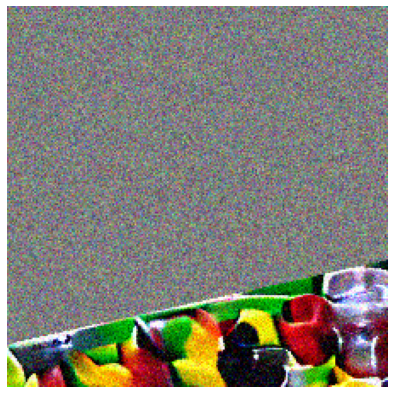

Generation


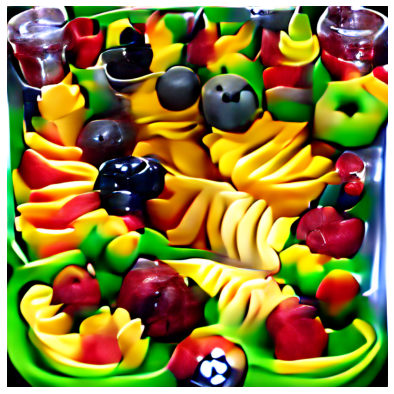

loss: -0.2841796875 
iteration: 80
Augmented cropped exaple


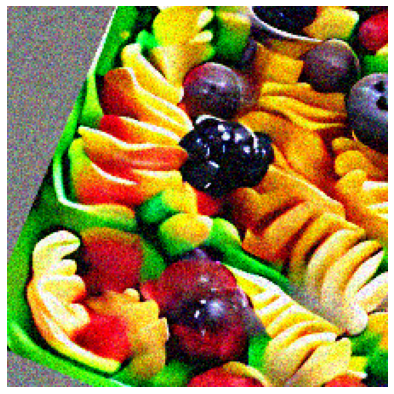

Generation


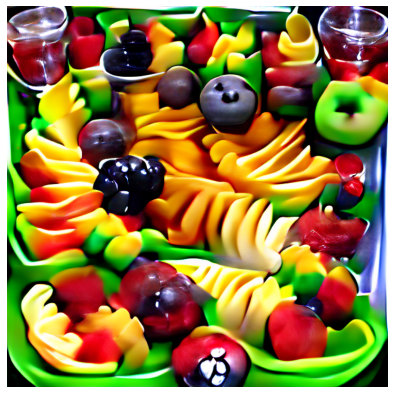

loss: -0.25 
iteration: 90


KeyboardInterrupt: ignored

In [14]:
# Generate the image
torch.cuda.empty_cache()
include = ['Fruit tray']
exclude = 'watermark'
extras = ""
w1 = 1
w2 = 1
noise_factor = .22
total_iter = 400

torch.cuda.memory_summary(device=None, abbreviated=False)

include_enc, exclude_enc, extras_enc = createEncoding(include, exclude, extras)
res_img, res_z = training_loop(Params, optimizer, show_crop = True)

In [ ]:
# create a video of images
def interpolate(res_z_list, duration_list):
  gen_img_list = []
  fps = 25

  for idx, (z, duration) in enumerate(zip(res_z_list, duration_list)):
    num_steps = int(duration * fps)
    z1 = z
    z2 = res_z_list[(idx + 1) %len(res_z_list)] # 1 x 256 x 14 x 25 (225/16, 400/16)

    for step in range(num_steps):
      alpha = math.sin(1.5*step/num_steps)**6
      z_new = alpha * z2 + (1 - alpha) * z1

      new_gen = norm_data(generator(z_new).cpu())[0] # 3 x 224 x 400
      new_img = T.ToPILImage(mode = 'RGB')(new_gen)
      gen_img_list.append(new_img)

  return gen_img_list

durations = [2, 2, 2, 2, 2]
interp_result_img_list = interpolate(res_z, durations)

In [ ]:
# create viedo
out_video_path = f"../res2.mp4"
writer = imageio.get_writer(out_video_path, fps = 25)
for pil_img in interp_result_img_list:
  img = np.array(pil_img, dtype = np.uint8)
  writer.append_data(img)

writer.close()

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('../res2.mp4', 'rb').read()
data = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>""" % data)